In [4]:
!pip install -q unipka py3Dmol

In [5]:
import unipka
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

calc = unipka.UnipKa(use_simple_smarts=False)

Get microstate distribution at target pH

In [6]:
mol = Chem.MolFromSmiles("[H]OC(=O)C([H])([H])N([H])[H]")
distribution_df = calc.get_distribution(mol, pH=2)
distribution_df

,charge,smiles,free_energy,ph_adjusted_free_energy,boltzmann_factor,population,relative_free_energy,relative_ph_adjusted_free_energy,mol,is_query_mol
0,1,[NH3+]CC(=O)O,-2.695787,-13.068691,473871.150264,6.506041e-01,9.747550,0.000000,<rdkit.Chem.rdchem.Mol object at 0x10a351540>,False
1,0,[NH3+]CC(=O)[O-],-12.443336,-12.443336,253555.113038,3.481199e-01,0.000000,0.625354,<rdkit.Chem.rdchem.Mol object at 0x361a46ab0>,False
2,1,NCC(O)=[OH+],3.542492,-6.830412,925.572164,1.270770e-03,15.985828,6.238279,<rdkit.Chem.rdchem.Mol object at 0x361a465e0>,False
3,0,NCC(=O)O,-1.168797,-1.168797,3.218120,4.418337e-06,11.274539,11.899893,<rdkit.Chem.rdchem.Mol object at 0x361a46570>,True
4,2,[NH3+]CC(O)=[OH+],21.323996,0.578188,0.560914,7.701098e-07,33.767332,13.646879,<rdkit.Chem.rdchem.Mol object at 0x361a46a40>,False
5,-1,NCC(=O)[O-],-5.467205,4.905699,0.007404,1.016573e-08,6.976132,17.974390,<rdkit.Chem.rdchem.Mol object at 0x361a466c0>,False


You can pass in either a SMILES string or RDKit molecule. If the molecule has 3D coordinates, all enumerated microstates will be transplanted onto the reference, and the placement of any new hydrogens will be optimised. In the viewer below, we can see only the hydrogens coordinates differ between all microstates.

This is particularly useful when i) determing the correct protomer from a crystal structure, as only heavy atoms are visible, and ii) determing the correct protomer from a Boltz structure, as only heavy atoms are predicted.

In [7]:
import py3Dmol

mol = Chem.MolFromSmiles("N1=CC=CC=C1NCCC")
AllChem.EmbedMolecule(mol)
distribution_df = calc.get_distribution(mol, pH=7.4)

viewer = py3Dmol.view(width=800, height=400, viewergrid=(1,2))

mols = distribution_df.mol.tolist()
for m in mols:
    mol1_block = Chem.MolToMolBlock(m)
    viewer.addModel(mol1_block, 'mol', viewer=(0,0))
    viewer.setStyle({'stick': {}}, viewer=(0,0))
                   # viewer=(0,0))

viewer.zoomTo(viewer=(0,0))
viewer


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Calculate basic pKa from either manually or automatically enumerated microstates

In [10]:
pka_manual = calc.get_macro_pka_from_macrostates(acid_macrostate=["c1cc[nH+]cc1"], base_macrostate=["c1ccncc1"])
pka_auto = calc.get_basic_micro_pka("c1ccncc1", idx=3)
assert np.isclose(pka_manual,pka_auto)

acidic_pka_of_conjugate_acid = calc.get_acidic_micro_pka("c1cc[nH+]cc1", idx=3)

assert np.isclose(acidic_pka_of_conjugate_acid,pka_manual)
pka_manual

5.329480042566694

Get dominant microstate at a specific pH

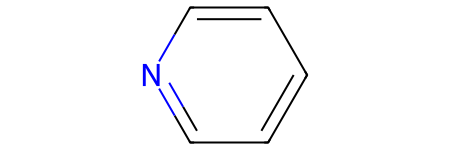

In [11]:
calc.get_dominant_microstate("N1=CC=CC=C1", pH=7.4)

Visualise the microstate distribution using the Jupyter widget

In [ ]:
calc.draw_distribution("N1=CC=CC=C1NC", mode="jupyter")

Visualise the microstate distribution using the matplotlib

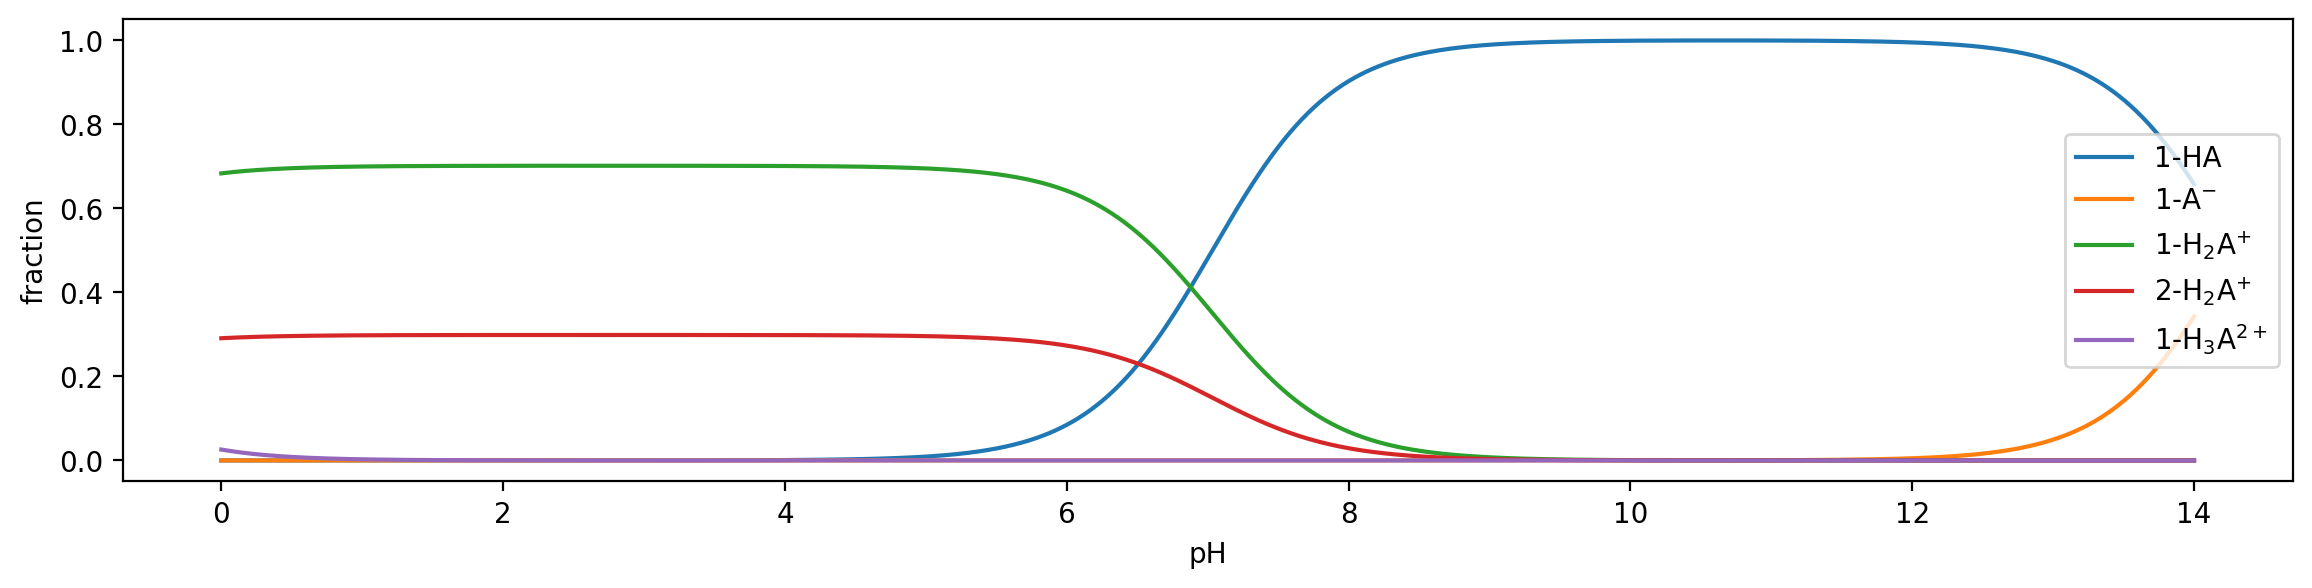

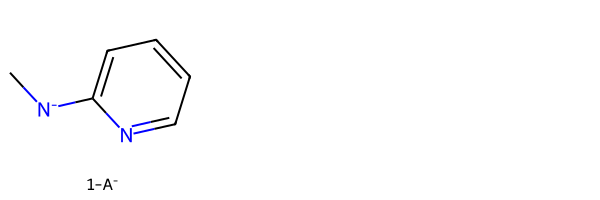

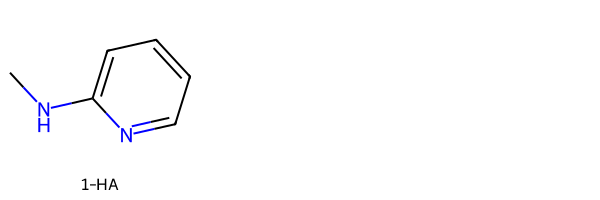

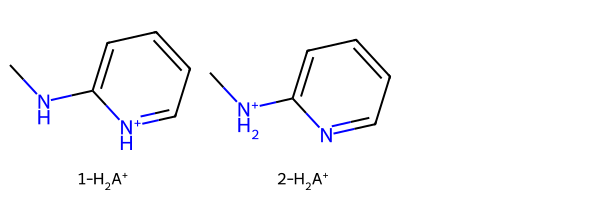

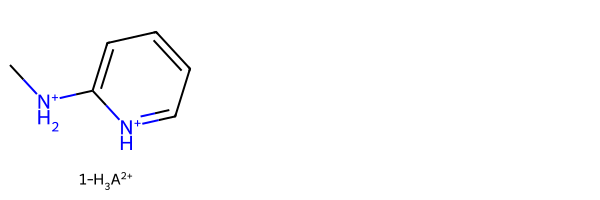

In [17]:
calc.draw_distribution("N1=CC=CC=C1NC", mode="matplotlib")

Calculate logD

In [20]:
calc.get_logd("N1=CC=CC=C1", pH=5.)

0.5860743553354998

Draw logD distribution

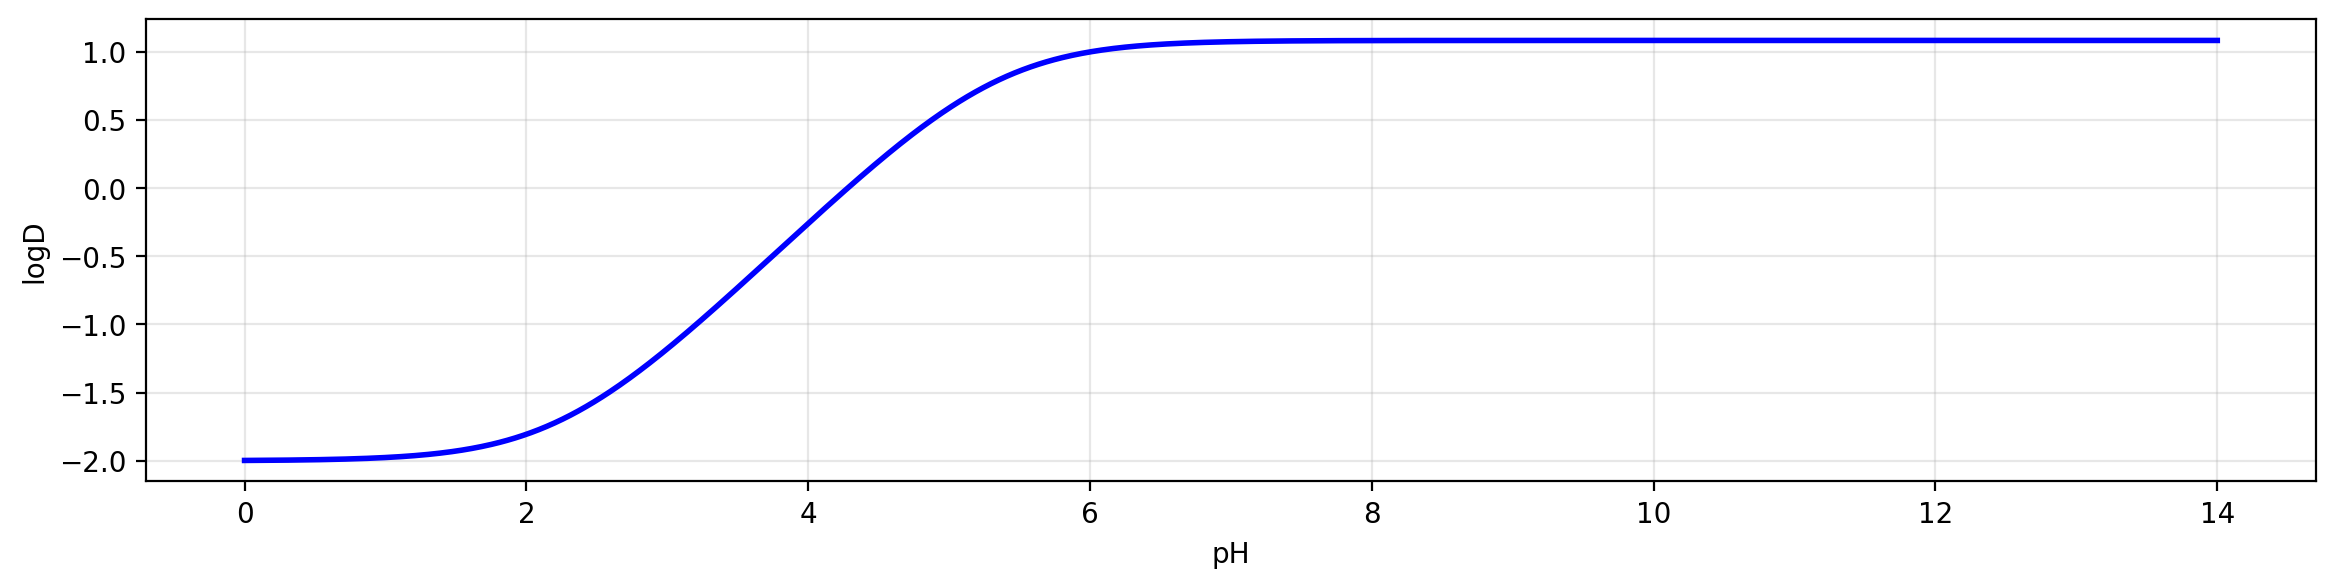

In [21]:
calc.draw_logd_distribution("N1=CC=CC=C1", mode="matplotlib")

Get the state penalty (the free energy required to shift the ionization equilibrium toward the neutral non-zwitterionic state). This can be used to calculate properties like following the methodology of [Rowan Sci and Lawrenz](https://chemrxiv.org/engage/api-gateway/chemrxiv/assets/orp/resource/item/68388349c1cb1ecda02ba65d/original/physics-informed-machine-learning-enables-rapid-macroscopic-p-ka-prediction.pdf).

In [22]:
state_penalty, reference_microstates_df  = calc.get_state_penalty("c1ccncc1", pH=5.)
print(state_penalty, "kcal/mol")
# Selects formally neutral microstates that minimize atom-centered charges, preferring non-zwitterionic forms over zwitterionic counterparts.
reference_microstates_df

0.677029255162599 kcal/mol


,charge,smiles,free_energy,ph_adjusted_free_energy,boltzmann_factor,population,relative_free_energy,relative_ph_adjusted_free_energy,mol,is_query_mol,abs_formal_charge,abs_atoms_charges
0,0,c1ccncc1,-5.406792,-5.406792,222.915257,0.318938,0.0,0.758656,<rdkit.Chem.rdchem.Mol object at 0x367997300>,True,0,0


Predict the probability that Kpuu > 0.3. This won't run in colab, as it needs the conda package `xtb`.

In [23]:
# Known drug with low CNS penetrance has a very low probability
fexofenadine = "CC(C)(C1=CC=C(C=C1)C(CCCN2CCC(CC2)C(C3=CC=CC=C3)(C4=CC=CC=C4)O)O)C(=O)O"
prob = calc.predict_brain_penetrance(fexofenadine)
prob

0.020604563619212292